In [100]:
# Build requests modules
import pandas as pd
import requests
import json
import asyncio
import aiohttp
import datetime
import time
import json
import numpy as np
import os
import pandas as pd
from pandas.io.json import json_normalize
import plotly
import redis
from multiprocessing.pool import ThreadPool
import asyncio
import aiohttp
import time
import urllib.request
from sqlalchemy import create_engine, text
import plotly.express as px

In [59]:
class nhlstats():

    def __init__(self):
        self.url = "https://statsapi.web.nhl.com/api/v1/"

    def player(self, player_id):
        url = self.url + "people" + "/{}".format(self.player_id)
        r = requests.get(url)
        js = r.json()
        df = pd.json_normalize(js)
        return df
    
    def playerSeasonStats(self, player_id, season):
        url = self.url + "people/{}/stats?stats=statsSingleSeason&season={}".format(player_id, season)
        r = requests.get(url)
        js = r.json()
        df = pd.json_normalize(js["stats"], record_path=["splits"])
        return df
    
    def seasons(self):
        url = self.url + "seasons"
        r = requests.get(url)
        js = r.json()
        df = pd.json_normalize(js["seasons"])
        return df

    def standings(self):
        url = self.url + "standings"
        js = requests.get(url).json()
        df = pd.json_normalize(js["records"], record_path=["teamRecords"])
        return df

    # IF YOU CAN COMBINE TEAMS INTO ONE FUNCTION WITH SUBFUNCTIONS
    def teamsList(self):
        url = self.url + "teams"
        js = requests.get(url).json()
        df = pd.json_normalize(js["teams"])
        return df

    def teamStats(self, team_id=None, season=None):

        if team_id is not None:
            url = self.url + "teams" + "/{}".format(team_id)
        else:
            url = self.url + "teams"

        try:
            if season is not None:
                r = requests.get(url + "?expand=team.stats" + "&season={}".format(season))
            else:
                #current season
                r = requests.get(url + "?expand=team.stats")
            js = r.json()
            df = pd.json_normalize(data=js["teams"], record_path=["teamStats", "splits"])
            return df
        except:
            df = pd.DataFrame()
            return df

    def teamRoster(self, team_id=None, season=None):

        if team_id is not None:
            url = self.url + "teams" + "/{}".format(team_id)
        else:
            url = self.url + "teams"

        if season is not None:
            r = requests.get(url + "?expand=team.roster" + "&season={}".format(season))
        else:
            #current season
            r = requests.get(url + "?expand=team.roster")
        js = r.json()
        df = pd.json_normalize(data=js["teams"], record_path=["roster", "roster"], meta=["id", "name"])
        return df

    def teamLogo(team_id):
        if team_id is None:
            return 'Error: team id required'
        else:
            url = 'https://www-league.nhlstatic.com/images/logos/teams-current-primary-light/' + str(team_id)  + '.svg'
            return url

In [44]:
df_stats = nhlstats().playerSeasonStats("8465009", "20192020")

In [45]:
df_stats

,season,stat.timeOnIce,stat.assists,stat.goals,stat.pim,stat.shots,stat.games,stat.hits,stat.powerPlayGoals,stat.powerPlayPoints,...,stat.shortHandedPoints,stat.shortHandedTimeOnIce,stat.blocked,stat.plusMinus,stat.points,stat.shifts,stat.timeOnIcePerGame,stat.evenTimeOnIcePerGame,stat.shortHandedTimeOnIcePerGame,stat.powerPlayTimeOnIcePerGame
0,20192020,1428:44,9,5,60,86,68,78,0,0,...,0,216:02,101,26,14,1665,21:00,17:46,03:10,00:03


In [ ]:
df_stats = nhlstats().playerSeasonStats("20192020")

In [48]:
engine = create_engine("sqlite:///C:\\Users\\WaterDev\\Documents\\GitHub\\portfolio_main\\hockeyviewer\\db_temp\\db2.db")
query_people = 'SELECT * FROM players'
df_people = pd.read_sql_query(sql=text(query_people), con=engine.connect())

In [87]:
def gather_players_tenyears():
    print("----> update_players")
    # List of current teamids and seasons to gather
    teamslist = nhlstats().teamsList().sort_values(by=['name'])
    teamids = teamslist['id'].tolist()
    print(teamids)
    seasons = [20122013, 20132014, 20142015, 20152016, 20162017, 20172018, 20182019, 20192020, 20202021, 20212022]
    seasons = [str(x) for x in seasons]
    # View roster for each team
    df_players = pd.DataFrame()
    for season in seasons:
        for team_id in teamids:
            try:
                df_roster = nhlstats().teamRoster(str(team_id), season)
                df_roster['season'] = season
                df_players = df_players.append(df_roster)
            except Exception as e:
                print("{} for season {} and team {}".format(e, season, team_id))
    # # Threader for building list of players
    # def build_playerlist(team_id, season):
    #     df_players = pd.DataFrame()
    #     df_roster = nhlstats().teamRoster(str(team_id), season)
    #     df_players = df_players.append(df_roster)
    #     return df_players
    # # Use threader
    # def run_downloader_playerlist(process:int, teamids:list, seasons:list):
    #     df_players = pd.DataFrame()
    #     results = ThreadPool(process).imap_unordered(build_playerlist, teamids, seasons)
    #     for r in results:
    #         df_players = df_players.append(r)
    #     return df_players
    # try:
    #     num_process = int(sys.argv[2])
    # except:
    #     num_process = 10
    # print(teamids)
    # print(seasons)
    # df_players = run_downloader_playerlist(num_process, teamids, seasons)
    df_players.to_sql('playersTenYears', con=engine, if_exists='replace')
    # # Save the dataframe in redis so that the Dash app, running on a separate
    # # process, can read it
    # redis_instance.hset(
    #     REDIS_HASH_NAME,
    #     REDIS_KEYS["CURRENT_PLAYERS"],
    #     json.dumps(
    #         df_players.to_dict(),
    #         # This JSON Encoder will handle things like numpy arrays
    #         # and datetimes
    #         cls=plotly.utils.PlotlyJSONEncoder,
    #     ),
    # )

In [80]:
engine = create_engine("sqlite:///C:\\Users\\WaterDev\\Documents\\GitHub\\portfolio_main\\hockeyviewer\\db_temp\\db2.db")
query_people = 'SELECT * FROM playersTenYears'
df_players = pd.read_sql_query(sql=text(query_people), con=engine.connect())

In [81]:
df_players

,index,jerseyNumber,person.id,person.fullName,person.link,position.code,position.name,position.type,position.abbreviation,id,name,season
0,0,8,8457981,Teemu Selanne,/api/v1/people/8457981,R,Right Wing,Forward,RW,24,Anaheim Ducks,20122013
1,1,11,8459442,Saku Koivu,/api/v1/people/8459442,C,Center,Forward,C,24,Anaheim Ducks,20122013
2,2,44,8460561,Sheldon Souray,/api/v1/people/8460561,D,Defenseman,Defenseman,D,24,Anaheim Ducks,20122013
3,3,18,8462041,Radek Dvorak,/api/v1/people/8462041,R,Right Wing,Forward,RW,24,Anaheim Ducks,20122013
4,4,32,8465042,Toni Lydman,/api/v1/people/8465042,D,Defenseman,Defenseman,D,24,Anaheim Ducks,20122013
...,...,...,...,...,...,...,...,...,...,...,...,...
10665,32,14,8481572,Ville Heinola,/api/v1/people/8481572,D,Defenseman,Defenseman,D,52,Winnipeg Jets,20212022
10666,33,91,8482149,Cole Perfetti,/api/v1/people/8482149,C,Center,Forward,C,52,Winnipeg Jets,20212022
10667,34,39,8482408,Jeff Malott,/api/v1/people/8482408,L,Left Wing,Forward,LW,52,Winnipeg Jets,20212022
10668,35,37,8476945,Connor Hellebuyck,/api/v1/people/8476945,G,Goalie,Goalie,G,52,Winnipeg Jets,20212022


In [77]:
df_players.columns

Index(['index', 'jerseyNumber', 'person.id', 'person.fullName', 'person.link',
       'position.code', 'position.name', 'position.type',
       'position.abbreviation', 'id', 'name'],
      dtype='object')

In [ ]:
# quick grab
print("----> update_players")
# List of current teamids
playerids = df_players['person.id'].unique()

# Threader for building list of players
def build_playerlist(team_id):
    df_players = pd.DataFrame()
    df_roster = nhlstats().teamRoster(str(team_id))
    df_players = df_players.append(df_roster)
    return df_players
# Use threader
def run_downloader_playerlist(process:int, teamids:list):
    df_players = pd.DataFrame()
    results = ThreadPool(process).imap_unordered(build_playerlist, teamids)
    for r in results:
        df_players = df_players.append(r)
    return df_players
try:
    num_process = int(sys.argv[2])
except:
    num_process = 10
df_players = run_downloader_playerlist(num_process, teamids)
df_players.to_sql('players', con=engine, if_exists='replace')

In [90]:
# using ten year player list get stats for each player, on each team, each season
df_plyr_stats = pd.DataFrame()
for player in df_players['person.id'].unique()[:20]:
    for season in df_players['season'].unique():
        df = nhlstats().playerSeasonStats(player, season)
        df['season'] = season
        df['person.id'] = player
        df_plyr_stats = df_plyr_stats.append(df)
df_plyr_stats = pd.to_sql('playerTenStats', con=engine, if_exists='replace')

C:\Users\WaterDev\AppData\Local\Temp\ipykernel_8624\2110702450.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_plyr_stats = df_plyr_stats.append(df)
C:\Users\WaterDev\AppData\Local\Temp\ipykernel_8624\2110702450.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_plyr_stats = df_plyr_stats.append(df)
C:\Users\WaterDev\AppData\Local\Temp\ipykernel_8624\2110702450.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_plyr_stats = df_plyr_stats.append(df)
C:\Users\WaterDev\AppData\Local\Temp\ipykernel_8624\2110702450.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_plyr_stats = df_plyr_stats.append(df)
C:\Users\WaterDev\Ap

AttributeError: module 'pandas' has no attribute 'to_sql'

In [91]:
df_plyr_stats

,season,stat.timeOnIce,stat.assists,stat.goals,stat.pim,stat.shots,stat.games,stat.hits,stat.powerPlayGoals,stat.powerPlayPoints,...,stat.shortHandedTimeOnIce,stat.blocked,stat.plusMinus,stat.points,stat.shifts,stat.timeOnIcePerGame,stat.evenTimeOnIcePerGame,stat.shortHandedTimeOnIcePerGame,stat.powerPlayTimeOnIcePerGame,person.id
0,20122013,721:51,12.0,12.0,28.0,96.0,46.0,8.0,3.0,7.0,...,00:53,10.0,-10.0,24.0,871.0,15:41,13:29,00:01,02:10,8457981
0,20132014,904:05,18.0,9.0,12.0,111.0,64.0,15.0,4.0,8.0,...,01:08,8.0,8.0,27.0,1109.0,14:07,11:42,00:01,02:24,8457981
0,20122013,827:13,19.0,8.0,18.0,55.0,47.0,31.0,4.0,8.0,...,98:28,15.0,4.0,27.0,1121.0,17:36,13:44,02:05,01:45,8459442
0,20132014,978:09,18.0,11.0,46.0,81.0,65.0,29.0,0.0,0.0,...,102:06,30.0,3.0,29.0,1445.0,15:02,12:48,01:34,00:39,8459442
0,20122013,920:53,10.0,7.0,52.0,80.0,44.0,34.0,2.0,5.0,...,109:45,58.0,19.0,17.0,1096.0,20:55,16:36,02:29,01:49,8460561
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,20172018,1223:40,26.0,17.0,73.0,141.0,74.0,150.0,1.0,7.0,...,00:35,14.0,1.0,43.0,1477.0,16:32,14:30,00:00,02:01,8474034
0,20182019,1048:33,18.0,10.0,64.0,118.0,74.0,135.0,2.0,11.0,...,00:00,7.0,-3.0,28.0,1287.0,14:10,12:13,00:00,01:57,8474034
0,20192020,794:29,14.0,9.0,71.0,80.0,64.0,104.0,1.0,3.0,...,01:23,13.0,4.0,23.0,1038.0,12:24,10:52,00:01,01:31,8474034
0,20202021,637:36,14.0,4.0,60.0,46.0,55.0,75.0,2.0,4.0,...,00:00,6.0,2.0,18.0,838.0,11:35,09:59,00:00,01:35,8474034


In [92]:
df_plyr_stats.columns

Index(['season', 'stat.timeOnIce', 'stat.assists', 'stat.goals', 'stat.pim',
       'stat.shots', 'stat.games', 'stat.hits', 'stat.powerPlayGoals',
       'stat.powerPlayPoints', 'stat.powerPlayTimeOnIce', 'stat.evenTimeOnIce',
       'stat.penaltyMinutes', 'stat.faceOffPct', 'stat.shotPct',
       'stat.gameWinningGoals', 'stat.overTimeGoals', 'stat.shortHandedGoals',
       'stat.shortHandedPoints', 'stat.shortHandedTimeOnIce', 'stat.blocked',
       'stat.plusMinus', 'stat.points', 'stat.shifts', 'stat.timeOnIcePerGame',
       'stat.evenTimeOnIcePerGame', 'stat.shortHandedTimeOnIcePerGame',
       'stat.powerPlayTimeOnIcePerGame', 'person.id'],
      dtype='object')

In [93]:
# combine with player attributes for comparison
df_people.columns

Index(['index', 'id', 'fullName', 'link', 'firstName', 'lastName',
       'primaryNumber', 'birthDate', 'currentAge', 'birthCity',
       'birthStateProvince', 'birthCountry', 'nationality', 'height', 'weight',
       'active', 'alternateCaptain', 'captain', 'rookie', 'shootsCatches',
       'rosterStatus', 'currentTeam.id', 'currentTeam.name',
       'currentTeam.link', 'primaryPosition.code', 'primaryPosition.name',
       'primaryPosition.type', 'primaryPosition.abbreviation'],
      dtype='object')

In [95]:
df_stats_attr = df_plyr_stats.merge(df_people, left_on='person.id', right_on='id', how='left')
df_stats_attr

,season,stat.timeOnIce,stat.assists,stat.goals,stat.pim,stat.shots,stat.games,stat.hits,stat.powerPlayGoals,stat.powerPlayPoints,...,rookie,shootsCatches,rosterStatus,currentTeam.id,currentTeam.name,currentTeam.link,primaryPosition.code,primaryPosition.name,primaryPosition.type,primaryPosition.abbreviation
0,20122013,721:51,12.0,12.0,28.0,96.0,46.0,8.0,3.0,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20132014,904:05,18.0,9.0,12.0,111.0,64.0,15.0,4.0,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20122013,827:13,19.0,8.0,18.0,55.0,47.0,31.0,4.0,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,20132014,978:09,18.0,11.0,46.0,81.0,65.0,29.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,20122013,920:53,10.0,7.0,52.0,80.0,44.0,34.0,2.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,20172018,1223:40,26.0,17.0,73.0,141.0,74.0,150.0,1.0,7.0,...,0.0,L,Y,14.0,Tampa Bay Lightning,/api/v1/teams/14,L,Left Wing,Forward,LW
97,20182019,1048:33,18.0,10.0,64.0,118.0,74.0,135.0,2.0,11.0,...,0.0,L,Y,14.0,Tampa Bay Lightning,/api/v1/teams/14,L,Left Wing,Forward,LW
98,20192020,794:29,14.0,9.0,71.0,80.0,64.0,104.0,1.0,3.0,...,0.0,L,Y,14.0,Tampa Bay Lightning,/api/v1/teams/14,L,Left Wing,Forward,LW
99,20202021,637:36,14.0,4.0,60.0,46.0,55.0,75.0,2.0,4.0,...,0.0,L,Y,14.0,Tampa Bay Lightning,/api/v1/teams/14,L,Left Wing,Forward,LW


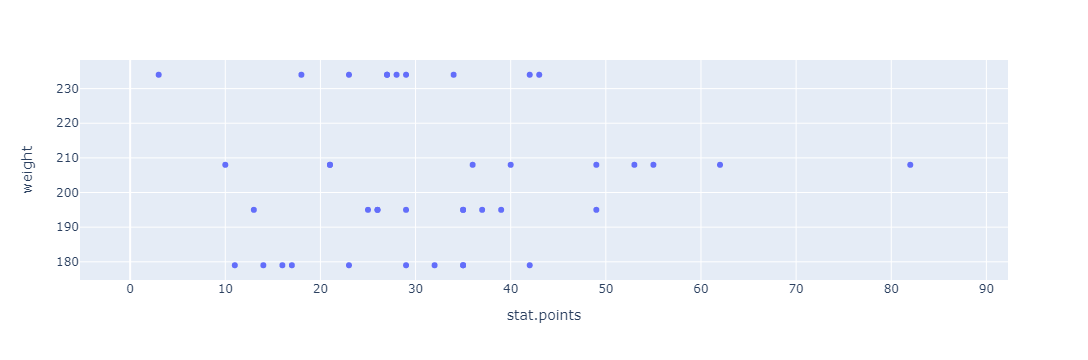

In [102]:
px.scatter(df_stats_attr, x='stat.points', y='weight')